# Stacked Regressions to predict House Prices 






The overall approach is  hopefully concise and easy to follow.. 

The features engeneering is rather parsimonious (at least compared to some others great scripts) . It is pretty much :

- **Imputing missing values**  by proceeding sequentially through the data

- **Transforming** some numerical variables that seem really categorical

- **Label Encoding** some categorical variables that may contain information in their ordering set

-  [**Box Cox Transformation**][4] of skewed features (instead of log-transformation) : This gave me a **slightly better result** both on leaderboard and cross-validation.

- ** Getting dummy variables** for categorical features. 

Then we choose many base models (mostly sklearn based models + sklearn API of  DMLC's [XGBoost][5] and Microsoft's [LightGBM][6]), cross-validate them on the data before stacking/ensembling them. The key here is to make the (linear) models robust to outliers. This improved the result both on LB and cross-validation. 

  [1]: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
  [2]:https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
  [3]: https://www.kaggle.com/apapiu/regularized-linear-models
  [4]: http://onlinestatbook.com/2/transformations/box-cox.html
  [5]: https://github.com/dmlc/xgboost
 [6]: https://github.com/Microsoft/LightGBM
 [7]: https://www.kaggle.com/humananalog/xgboost-lasso





**Hope that at the end of this notebook, stacking will be clear for those, like myself, who found the concept not so easy to grasp**

In [1]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from subprocess import check_output


In [2]:
#Now let's import and put the train and test datasets in  pandas dataframe

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [3]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


# Data Processing

In [4]:
train.describe(percentiles=[0.01,0.1,0.2,0.3,0.5,0.6,0.7,0.8,0.9,0.99])

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000,1201.000,1460.000,1460.000,1460.000,1460.000,1460.000,1452.000,1460.000,1460.000,...,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000
mean,56.897,70.050,10516.828,6.099,5.575,1971.268,1984.866,103.685,443.640,46.549,...,94.245,46.660,21.954,3.410,15.061,2.759,43.489,6.322,2007.816,180921.196
std,42.301,24.285,9981.265,1.383,1.113,30.203,20.645,181.066,456.098,161.319,...,125.339,66.256,61.119,29.317,55.757,40.177,496.123,2.704,1.328,79442.503
min,20.000,21.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000,34900.000
1%,20.000,21.000,1680.000,3.000,3.000,1899.180,1950.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000,61815.970
10%,20.000,44.000,5000.000,5.000,5.000,1924.900,1950.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,2006.000,106475.000
20%,20.000,53.000,7078.400,5.000,5.000,1947.800,1961.800,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,2006.000,124000.000
30%,20.000,60.000,8063.700,5.000,5.000,1958.000,1971.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,2007.000,135500.000
50%,50.000,69.000,9478.500,6.000,5.000,1973.000,1994.000,0.000,383.500,0.000,...,0.000,25.000,0.000,0.000,0.000,0.000,0.000,6.000,2008.000,163000.000
60%,60.000,74.000,10198.200,6.000,5.000,1984.000,1998.000,16.000,525.600,0.000,...,100.000,40.000,0.000,0.000,0.000,0.000,0.000,7.000,2008.000,179280.000


# Outliers

[Documentation][1] for the Ames Housing Data indicates that there are outliers present in the training data
[1]: http://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt

Let's explore these outliers


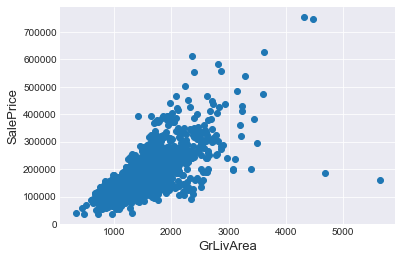

In [5]:

fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


We can see at the bottom right two with extremely large GrLivArea that are of a low price. These values are huge oultliers.
Therefore, we can safely delete them.

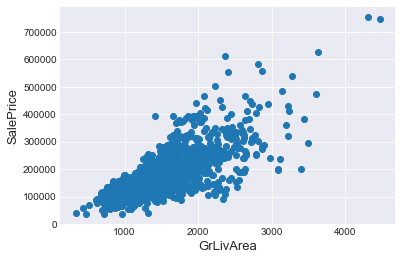

In [6]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

###Note : 
 Outliers removal is note always safe.  We decided to delete these two as they are very huge and  really  bad ( extremely large areas for very low  prices). 

There are probably others outliers in the training data.   However, removing all them  may affect badly our models if ever there were also  outliers  in the test data. That's why , instead of removing them all, we will just manage to make some of our  models robust on them. You can refer to  the modelling part of this notebook for that. 

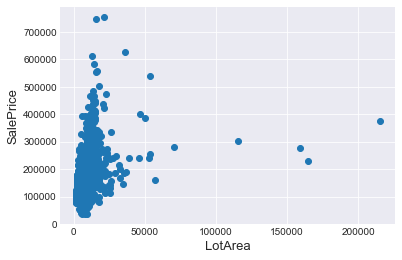

In [7]:

fig, ax = plt.subplots()
ax.scatter(x = train['LotArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LotArea', fontsize=13)
plt.show()

In [8]:
train.shape

(1458, 80)

In [9]:
train = train.drop(train[(train['LotArea']>100000)].index)


In [10]:
train.shape

(1454, 80)

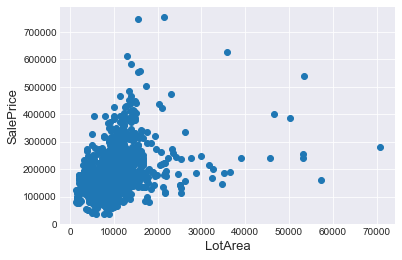

In [11]:
fig, ax = plt.subplots()
ax.scatter(x = train['LotArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LotArea', fontsize=13)
plt.show()

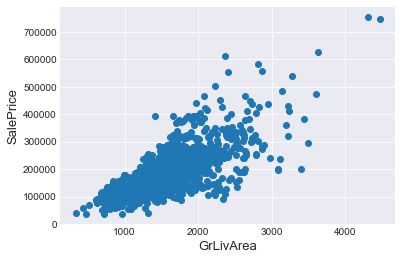

In [12]:
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [13]:
def plot_(df, target, column):
    fig, ax = plt.subplots()
    ax.scatter(df[column], df[target])
    plt.ylabel(target, fontsize=13)
    plt.xlabel(column, fontsize=13)
    plt.show()

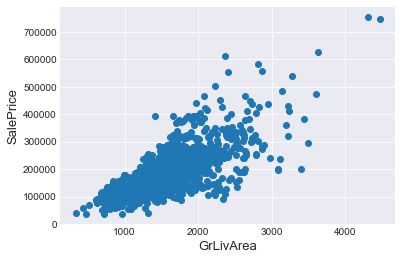

In [14]:
plot_(train, 'SalePrice', 'GrLivArea')

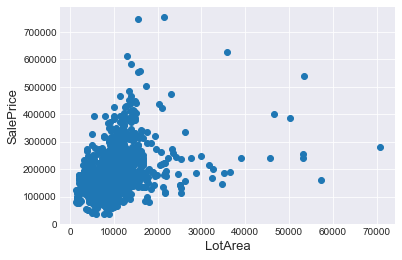

In [15]:
plot_(train, 'SalePrice', 'LotArea')

### Target Variable

**SalePrice** is the variable we need to predict. So let's do some analysis on this variable first.


 mu = 180617.09 and sigma = 79299.98



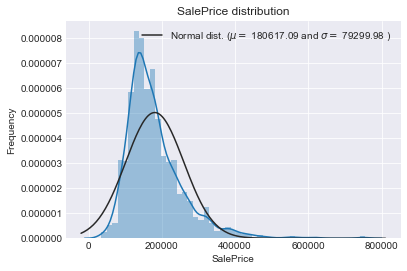

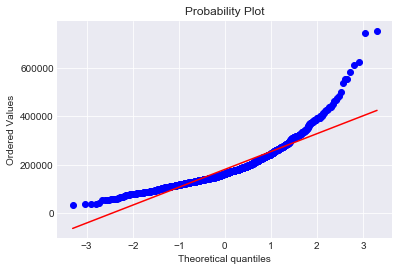

In [16]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

The target variable is right skewed.  As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

 **Log-transformation of the target variable**


 mu = 12.02 and sigma = 0.40



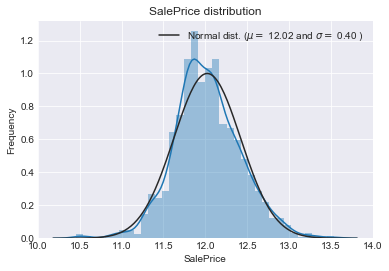

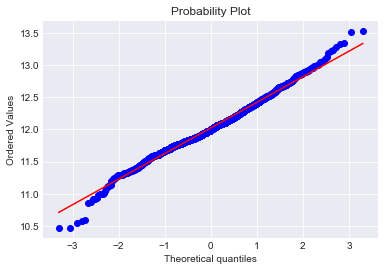

In [17]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


The skew seems now corrected and the data appears more normally distributed. 

### Features engineering

let's first  concatenate the train and test data in the same dataframe

In [18]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2913, 79)


In [19]:
y_train

array([ 12.24769912,  12.10901644,  12.31717117, ...,  12.49313327,
        11.86446927,  11.90159023])

###Missing Data

In [20]:
train.groupby(['PoolQC']).count()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
PoolQC,,,,,,,,,,,,,,,,,,,,,
Ex,2,2,2,2,2,0,2,2,2,2,...,2,2,2,0,2,2,2,2,2,2
Fa,2,2,2,2,2,0,2,2,2,2,...,2,2,2,1,2,2,2,2,2,2
Gd,2,2,1,2,2,0,2,2,2,2,...,2,2,2,0,2,2,2,2,2,2


In [21]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(30)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.464
Alley,93.203
Fence,80.398
FireplaceQu,48.747
LotFrontage,16.581
GarageQual,5.458
GarageCond,5.458
GarageFinish,5.458
GarageYrBlt,5.458


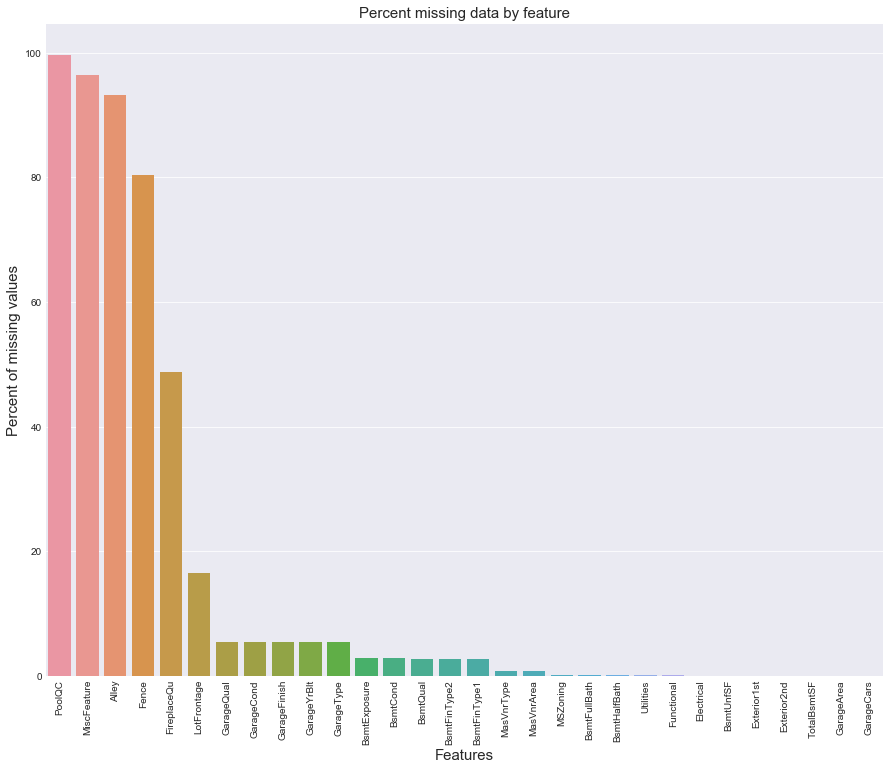

In [22]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

**Data Correlation**


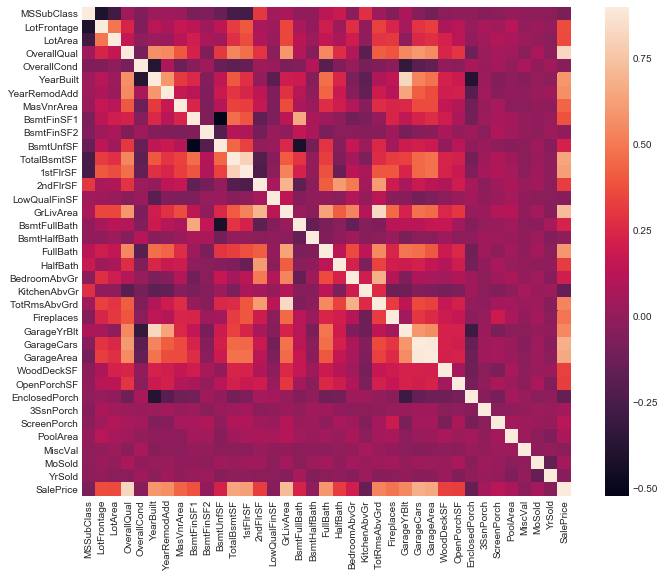

In [23]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

### Imputing missing values 

We impute them  by proceeding sequentially  through features with missing values 

- **PoolQC** : data description says NA means "No  Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general. 

In [24]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

- **MiscFeature** : data description says NA means "no misc feature"


In [25]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

- **Alley** : data description says NA means "no alley access"

In [26]:
all_data["Alley"] = all_data["Alley"].fillna("None")

- **Fence** : data description says NA means "no fence"

In [27]:
all_data["Fence"] = all_data["Fence"].fillna("None")

- **FireplaceQu** : data description says NA means "no fireplace"

In [28]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

- **LotFrontage** : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can **fill in missing values by the median LotFrontage of the neighborhood**.

In [29]:
sum(all_data['LotFrontage'].isnull())

483

In [30]:
all_data.groupby("Neighborhood")["LotFrontage"].agg({'LotFrontage':'median'})

,LotFrontage
Neighborhood,
Blmngtn,43.000
Blueste,24.000
BrDale,21.000
BrkSide,51.000
ClearCr,80.500
CollgCr,70.000
Crawfor,70.000
Edwards,64.500
Gilbert,64.000


In [31]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

- **GarageType, GarageFinish, GarageQual and GarageCond** : Replacing missing data with None

In [32]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

- **GarageYrBlt, GarageArea and GarageCars** : Replacing missing data with 0 (Since No garage = no cars in such garage.)


In [33]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

- **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath** : missing values are likely zero for having no basement

In [34]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : For all these categorical basement-related features, NaN means that there is no  basement.


In [35]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

- **MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type. 


In [36]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- **MSZoning (The general zoning classification)** :  'RL' is by far  the most common value.  So we can fill in missing values with 'RL'


In [37]:
all_data.iloc[225]['MSZoning']

'RM'

In [38]:
all_data.groupby(["Neighborhood",'MSZoning']).count()['1stFlrSF']

Neighborhood  MSZoning
Blmngtn       RL           25
              RM            3
Blueste       RM           10
BrDale        RM           30
BrkSide       RL           43
              RM           65
ClearCr       RL           42
CollgCr       RL          253
              RM           14
Crawfor       RH            2
              RL           91
              RM           10
Edwards       RH            2
              RL          178
              RM           12
Gilbert       RL          165
IDOTRR        C (all)      22
              RM           68
MeadowV       RM           37
Mitchel       RL          104
              RM            9
NAmes         RH            7
              RL          436
NPkVill       RL           23
NWAmes        RL          131
NoRidge       RL           71
NridgHt       RL          165
              RM            1
OldTown       C (all)       2
              RL           39
              RM          198
SWISU         C (all)       1
              RH 

In [39]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

- **Utilities** : For this categorical feature all records are "AllPub", except for one "NoSeWa"  and 2 NA . Since the house with 'NoSewa' is in the training set, **this feature won't help in predictive modelling**. We can then safely  remove it.


In [40]:
all_data.groupby(['Utilities']).count()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
Utilities,,,,,,,,,,,,,,,,,,,,,
AllPub,2910,2910,2910,2910,2910,2910,2910,2910,2910,2910,...,2910,2909,2910,2910,2910,2910,2910,2910,2910,2910
NoSeWa,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [41]:
all_data = all_data.drop(['Utilities'], axis=1)

- **Functional** : data description says NA means typical

In [42]:
all_data.groupby(['Functional']).count()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
Functional,,,,,,,,,,,,,,,,,,,,,
Maj1,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
Maj2,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
Min1,65,65,65,65,65,65,65,65,65,65,...,65,65,65,65,65,65,65,65,65,65
Min2,70,70,70,70,70,70,70,70,70,70,...,70,70,70,70,70,70,70,70,70,70
Mod,35,35,35,35,35,35,35,35,35,35,...,35,35,35,35,35,35,35,35,35,35
Sev,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Typ,2711,2711,2711,2711,2711,2711,2711,2711,2711,2711,...,2711,2710,2711,2711,2711,2711,2711,2711,2711,2711


In [43]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

- **Electrical** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.


In [44]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

- **KitchenQual**: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent)  for the missing value in KitchenQual.


In [45]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

- **Exterior1st and Exterior2nd** : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string


In [46]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

- **SaleType** : Fill in again with most frequent which is "WD"

In [47]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

- **MSSubClass** : Na most likely means No building class. We can replace missing values with None


In [48]:

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")



Is there any remaining missing value ? 

In [49]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


It remains no missing value.


### More features engeneering

**Transforming some numerical variables that are really categorical**

In [50]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,None,3,1Fam,TA,No,706.000,0.000,...,Normal,WD,0,Pave,8,856.000,0,2003,2003,2008
1,1262,0,0,None,3,1Fam,TA,Gd,978.000,0.000,...,Normal,WD,0,Pave,6,1262.000,298,1976,1976,2007
2,920,866,0,None,3,1Fam,TA,Mn,486.000,0.000,...,Normal,WD,0,Pave,6,920.000,0,2001,2002,2008
3,961,756,0,None,3,1Fam,Gd,No,216.000,0.000,...,Abnorml,WD,0,Pave,7,756.000,0,1915,1970,2006
4,1145,1053,0,None,4,1Fam,TA,Av,655.000,0.000,...,Normal,WD,0,Pave,9,1145.000,192,2000,2000,2008


In [51]:
all_data['MSSubClass'].head()

0    60
1    20
2    60
3    70
4    60
Name: MSSubClass, dtype: int64

In [52]:
all_data['OverallCond'].head()

0    5
1    8
2    5
3    5
4    5
Name: OverallCond, dtype: int64

In [53]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
#all_data['MoSold'] = all_data['MoSold'].astype(str)



#### Transforming more numiercal variables

Summer holiday market is hot

In [54]:
#all_data['MoSold'] = all_data['MoSold'].astype(int)
all_data['Is_Summer'] = all_data['MoSold'].apply(lambda x: x in (5,6,7,8)).astype(int)
all_data['Is_Winter'] = all_data['MoSold'].apply(lambda x: x in (12,1)).astype(int)
all_data['Is_Other'] = all_data['MoSold'].apply(lambda x: x in (2,3,4,9,10,11)).astype(int)
all_data.drop(['MoSold'],1,inplace=True)

Age of the house

In [55]:
avg_price = train.groupby(['Neighborhood']).agg({'SalePrice':['sum'],'GrLivArea':['sum'] })

In [56]:
avg_price['avg_price'] = avg_price[('SalePrice', 'sum')]/avg_price[('GrLivArea', 'sum')]

In [57]:
avg_price

,SalePrice,GrLivArea,avg_price
,sum,sum,
Neighborhood,,,
Blmngtn,206.880,24275,0.009
Blueste,23.653,2785,0.008
BrDale,184.766,18291,0.010
BrkSide,677.425,69778,0.010
ClearCr,317.567,46099,0.007
CollgCr,1824.547,222075,0.008
Crawfor,622.540,91372,0.007
Edwards,1147.122,123686,0.009


In [58]:
all_data['HouseAge'] = 2017 - all_data['YearBuilt']

In [59]:
all_data.drop(['YearBuilt'],1,inplace=True)

In [60]:
all_data[['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold']]

,FireplaceQu,BsmtQual,BsmtCond,GarageQual,GarageCond,ExterQual,ExterCond,HeatingQC,PoolQC,KitchenQual,...,GarageFinish,LandSlope,LotShape,PavedDrive,Street,Alley,CentralAir,MSSubClass,OverallCond,YrSold
0,None,Gd,TA,TA,TA,Gd,TA,Ex,None,Gd,...,RFn,Gtl,Reg,Y,Pave,None,Y,60,5,2008
1,TA,Gd,TA,TA,TA,TA,TA,Ex,None,TA,...,RFn,Gtl,Reg,Y,Pave,None,Y,20,8,2007
2,TA,Gd,TA,TA,TA,Gd,TA,Ex,None,Gd,...,RFn,Gtl,IR1,Y,Pave,None,Y,60,5,2008
3,Gd,TA,Gd,TA,TA,TA,TA,Gd,None,Gd,...,Unf,Gtl,IR1,Y,Pave,None,Y,70,5,2006
4,TA,Gd,TA,TA,TA,Gd,TA,Ex,None,Gd,...,RFn,Gtl,IR1,Y,Pave,None,Y,60,5,2008
5,None,Gd,TA,TA,TA,TA,TA,Ex,None,TA,...,Unf,Gtl,IR1,Y,Pave,None,Y,50,5,2009
6,Gd,Ex,TA,TA,TA,Gd,TA,Ex,None,Gd,...,RFn,Gtl,Reg,Y,Pave,None,Y,20,5,2007
7,TA,Gd,TA,TA,TA,TA,TA,Ex,None,TA,...,RFn,Gtl,IR1,Y,Pave,None,Y,60,6,2009
8,TA,TA,TA,Fa,TA,TA,TA,Gd,None,TA,...,Unf,Gtl,Reg,Y,Pave,None,Y,50,5,2008
9,TA,TA,TA,Gd,TA,TA,TA,Ex,None,TA,...,RFn,Gtl,Reg,Y,Pave,None,Y,190,6,2008


In [61]:
from sklearn.preprocessing import LabelEncoder

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))




Shape all_data: (2913, 80)


In [62]:
all_data[['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold']]

,FireplaceQu,BsmtQual,BsmtCond,GarageQual,GarageCond,ExterQual,ExterCond,HeatingQC,PoolQC,KitchenQual,...,GarageFinish,LandSlope,LotShape,PavedDrive,Street,Alley,CentralAir,MSSubClass,OverallCond,YrSold
0,3,2,4,5,5,2,4,0,3,2,...,2,0,3,2,1,1,1,10,4,2
1,5,2,4,5,5,3,4,0,3,3,...,2,0,3,2,1,1,1,5,7,1
2,5,2,4,5,5,2,4,0,3,2,...,2,0,0,2,1,1,1,10,4,2
3,2,4,1,5,5,3,4,2,3,2,...,3,0,0,2,1,1,1,11,4,0
4,5,2,4,5,5,2,4,0,3,2,...,2,0,0,2,1,1,1,10,4,2
5,3,2,4,5,5,3,4,0,3,3,...,3,0,0,2,1,1,1,9,4,3
6,2,0,4,5,5,2,4,0,3,2,...,2,0,3,2,1,1,1,5,4,1
7,5,2,4,5,5,3,4,0,3,3,...,2,0,0,2,1,1,1,10,5,3
8,5,4,4,1,5,3,4,2,3,3,...,3,0,3,2,1,1,1,9,4,2
9,5,4,4,2,5,3,4,0,3,3,...,2,0,3,2,1,1,1,4,5,2


**Adding one more important feature**

Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

In [63]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']


**Skewed features**

In [64]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)



Skew in numerical features: 



,Skew
MiscVal,21.948
PoolArea,17.676
LowQualFinSF,12.076
3SsnPorch,11.364
LandSlope,4.955
KitchenAbvGr,4.297
BsmtFinSF2,4.159
EnclosedPorch,3.999
ScreenPorch,3.942
BsmtHalfBath,3.941


**Box Cox Transformation of (highly) skewed features**

We use the scipy  function boxcox1p which computes the Box-Cox transformation of **\\(1 + x\\)**. 

Note that setting \\( \lambda = 0 \\) is equivalent to log1p used above for the target variable.  

See [this page][1] for more details on Box Cox Transformation as well as [the scipy function's page][2]
[1]: http://onlinestatbook.com/2/transformations/box-cox.html
[2]: https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html

In [65]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 61 skewed numerical features to Box Cox transform


**Getting dummy categorical features**

In [66]:

all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2913, 222)


Getting the new train and test sets. 

In [67]:
train = all_data[:ntrain]
test = all_data[ntrain:]


In [68]:
train.shape

(1454, 222)

In [69]:
test.shape

(1459, 222)

## Modelling

**Import librairies**

In [99]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb   #pip install xgboost or conda install xgboost
import lightgbm as lgb #pip install lightgbm or conda install lightgbm



# Single_Model_RF

Use **cross validation** to tune the parameters of the model

In [71]:
import pandas as pd
import numpy as np
from sklearn import tree
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from math import log
import matplotlib.pyplot as plt
%matplotlib inline
import graphviz # conda install gra... or pip install graphviz
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.grid_search import GridSearchCV
from time import time
from operator import itemgetter
from sklearn.cross_validation import  cross_val_score
def run_gridsearch(X, y, clf, param_grid,  cv=5):
    """Run a grid search for best Decision Tree parameters.

    Args
    ----
    X -- features
    y -- targets (classes)
    cf -- scikit-learn Decision Tree
    param_grid -- [dict] parameter settings to test
    cv -- fold of cross-validation, default 5

    Returns
    -------
    top_params -- [dict] from report()
    """
    grid_search = GridSearchCV(clf,
                               param_grid=param_grid,
                               cv=cv)
    start = time()
    grid_search.fit(X, y)

    print(("\nGridSearchCV took {:.2f} "
           "seconds for {:d} candidate "
           "parameter settings.").format(time() - start,
                len(grid_search.grid_scores_)))

    top_params = report(grid_search.grid_scores_, 30)
    return  top_params


def report(grid_scores, n_top=30):
    """Report top n_top parameters settings, default n_top=3.

    Args
    ----
    grid_scores -- output from grid or random search
    n_top -- how many to report, of top models

    Returns
    -------
    top_params -- [dict] top parameter settings found in
                  search
    """
    top_scores = sorted(grid_scores,
                        key=itemgetter(1),
                        reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print(("Mean validation score: "
               "{0:.3f} (std: {1:.3f})").format(
               score.mean_validation_score,
               np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

    return top_scores[0].parameters

**HOME WORK**: Tune the parameter below and run this program , submit your solution

In [83]:
print("-- Grid Parameter Search via 10-fold CV")

# set of parameters to test
param_grid = {"criterion": [ "mse", "mae"],
              "min_samples_split": [ 30, 50, 60],
              "max_depth": [4, 5,6,7,8,9,10],
              "min_samples_leaf": [10],
              "n_estimators":[100,200]
              }

rf = RandomForestRegressor()

ts_gs = run_gridsearch(train, y_train, rf, param_grid, cv=10)

-- Grid Parameter Search via 10-fold CV

GridSearchCV took 5.64 seconds for 2 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.828 (std: 0.009)
Parameters: {'criterion': 'mse', 'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 30, 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.827 (std: 0.009)
Parameters: {'criterion': 'mse', 'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 30, 'n_estimators': 100}



In [84]:
print("\n-- Best Parameters:")
for k, v in ts_gs.items():
    print("parameter: {:<20s} setting: {}".format(k, v))


-- Best Parameters:
parameter: criterion            setting: mse
parameter: max_depth            setting: 4
parameter: min_samples_leaf     setting: 10
parameter: min_samples_split    setting: 30
parameter: n_estimators         setting: 200


In [85]:
# test the retuned best parameters
print("\n\n-- Testing best parameters [Grid]...")
dt_ts_gs = RandomForestRegressor(**ts_gs)
scores = cross_val_score(dt_ts_gs,train, y_train, cv=10)
print("mean: {:.3f} (std: {:.3f})".format(scores.mean(),
                                          scores.std()),
                                          end="\n\n" )



-- Testing best parameters [Grid]...
mean: 0.826 (std: 0.026)



In [86]:
dt_ts_gs.fit(train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=30,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [87]:
dt_ts_gs.predict(test.values)

array([ 11.7245969 ,  11.91937939,  11.98646494, ...,  11.93011581,
        11.64208793,  12.30378789])

In [88]:

pred = np.expm1(dt_ts_gs.predict(test.values))

In [89]:

sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = pred
sub.to_csv('rf_3.csv',index=False)



# Xgboost

**HOMEWORK**: find your best parameter

In [106]:
print("-- Grid Parameter Search via 10-fold CV")

# set of parameters to test
#this is the only difference
param_grid = {"gamma":[0.0468,0.05], 
              "learning_rate":[0.005], # [0.005, 0.2]
               "max_depth":[6],   # [3-20]
                "n_estimators":[100, 300000], # 100-30k
                 "reg_lambda":[0.8571],
                        
              }


xgb_reg = xgb.XGBRegressor()


ts_gs = run_gridsearch(train, y_train, xgb_reg, param_grid, cv=3)

-- Grid Parameter Search via 10-fold CV

GridSearchCV took 2.64 seconds for 1 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.855 (std: 0.009)
Parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'reg_lambda': 0.8571}



In [107]:
print("\n-- Best Parameters:")
for k, v in ts_gs.items():
    print("parameter: {:<20s} setting: {}".format(k, v))


-- Best Parameters:
parameter: learning_rate        setting: 0.05
parameter: max_depth            setting: 6
parameter: n_estimators         setting: 100
parameter: reg_lambda           setting: 0.8571


In [111]:
# test the retuned best parameters
print("\n\n-- Testing best parameters [Grid]...")
dt_ts_gs = xgb.XGBRegressor(**ts_gs)
scores = cross_val_score(dt_ts_gs,train, y_train, cv=10)
print("mean: {:.3f} (std: {:.3f})".format(scores.mean(),
                                          scores.std()),
                                          end="\n\n" )



-- Testing best parameters [Grid]...
mean: 0.864 (std: 0.016)



In [117]:
dt_ts_gs.fit(train,y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=0.8571,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [118]:
pred = np.expm1(dt_ts_gs.predict(test))

In [119]:

sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = pred
sub.to_csv('xgb.csv',index=False)

# Home problem 3

* install lightgbm
* repeat the above process/codes
* find the best parameter/mode for light gbm
* submit your resluts to kaggle

In [121]:
lgb.LGBMRegressor(n_jobs=-1)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

In [ ]:
# specify your configurations as a dict
param_grid = {
    'task': ['train'],
    'boosting_type': ['gbdt'],
    'objective': ['regression'],
    'metric': ['l2'],
    'num_leaves': [31],
    'learning_rate': [0.05, 0.1],
    'feature_fraction': [0.9],
    'bagging_fraction': [0.8],
    'bagging_freq': [5],
    'n_estimators':[1000,2000]
}
gbm = lgb.LGBMRegressor()
